In [2]:
import h5py 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

def get_label(path):
    f = h5py.File(path,'r')
    labels = f['label'][:].copy()
    f.close()
    return labels

train_labels = get_label('../../../../data/criteo_x1/train.h5')
valid_labels = get_label('../../../../data/criteo_x1/valid.h5')
test_labels = get_label('../../../../data/criteo_x1/test.h5')

train_range = range(len(train_labels))
valid_range = range(len(train_labels), len(train_labels)+len(valid_labels))
test_range = range(len(train_labels)+len(valid_labels), len(train_labels)+len(valid_labels)+len(test_labels))

train_labels.mean()

0.25622778140603164

In [3]:
base_path = '../../submission/submission_{}.csv'
model_names=[
    ('DCNv2_criteo_x1_posw0.1','bce'),
    ('DCNv2_criteo_x1_posw0.1_jrc_alpha0.4','jrc'),
    ('DCNv2_criteo_x1_posw0.1_combinedpair_alpha0.7','combined-pair'), 
    ]
all_labels = np.concatenate([train_labels, valid_labels, test_labels])
[_[1]for _ in model_names]

['bce', 'jrc', 'combined-pair']

In [4]:
def gen_df(model_names, group_setting):
    df = pd.DataFrame()
    df['label'] = all_labels
    for path, name in model_names:
        print(path,name)
        df[name] = pd.read_csv(base_path.format(path),usecols=['infer'])['infer']
        if group_setting is not None:
            if isinstance(group_setting,dict):
                df[name+'_group'] = pd.cut(df[name],bins=group_setting[name],include_lowest=True)
            else:
                df[name+'_group'] = pd.cut(df[name],bins=group_setting,include_lowest=True)
        
    return df

def get_three_ds(curr_df):
    curr_train = curr_df.iloc[train_range]
    curr_valid = curr_df.iloc[valid_range]
    curr_test = curr_df.iloc[test_range]
    return curr_train, curr_valid, curr_test

In [5]:
df = gen_df([('DCNv2_criteo_x1_posw0.1','bce')], None)

DCNv2_criteo_x1_posw0.1 bce


In [6]:
tmp_train,_,tmp_test = get_three_ds(df)
nums=45
tar = tmp_test
def get_threshold(col, nums):
    splits = np.array_split(col.sort_values(),nums)
    threshold = [min(_) for _ in splits] + [1]
    threshold[0] = 0
    return threshold

In [7]:
base_col = tar['bce']
threshold = get_threshold(base_col, nums)
print(threshold)

/home/amax/.conda/envs/text2emb/lib/python3.9/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


[0, 0.0009973951382562, 0.0016614120686426, 0.002283768961206, 0.0028977850452065, 0.0035189860500395, 0.004158261232078, 0.0048272609710693, 0.0055306935682892, 0.0062718009576201, 0.0070510837249457, 0.0078733237460255, 0.0087360842153429, 0.009656298905611, 0.0106274830177426, 0.0116577288135886, 0.0127567015588283, 0.0139197399839758, 0.0151674384251236, 0.0164969079196453, 0.0179174281656742, 0.0194563381373882, 0.0211090072989463, 0.0228971261531114, 0.0248441249132156, 0.0269581563770771, 0.0292551647871732, 0.0317719168961048, 0.0345537737011909, 0.0376291722059249, 0.0410633459687233, 0.0448992624878883, 0.0492228046059608, 0.0541107803583145, 0.0597317926585674, 0.0662734508514404, 0.0739296302199363, 0.0831404030323028, 0.0943229645490646, 0.1082492768764495, 0.1262256354093551, 0.150552824139595, 0.1854946911334991, 0.2416867613792419, 0.3558296859264374, 1]


In [8]:
def plot_baskets_paper(xs, ys, names, ls=None, color=None, xlabel='pctr bins', ylabel='bias', ann=True, title='My Plot'):
    for i, (y, name) in enumerate(zip(ys, names)):
        if ls is None or color is None:
            plt.plot(xs[i], y, label=name)
        else:
            plt.plot(xs[i], y, label=name, ls=ls[i], color=color[i])
        if ann:
            for j in range(len(xs[i])):
                plt.annotate(
                    str(round(y[j],3)), (xs[i][j], y[j]),
                    textcoords="offset points",
                    xytext=(0, 7), ha='center')

    plt.title(title)  # 添加标题
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axhline(0, ls='--')
    plt.tight_layout()

In [9]:
twitter_color = '#CAB80A'
base_color = '#221715'
jrc_color='#660A74'

In [10]:
bdf = gen_df(model_names, threshold)
bdf_train,_, bdf_test = get_three_ds(bdf)

DCNv2_criteo_x1_posw0.1 bce
DCNv2_criteo_x1_posw0.1_jrc_alpha0.4 jrc
DCNv2_criteo_x1_posw0.1_combinedpair_alpha0.7 combined-pair


In [11]:
def cal_bias(y_pred, y):
    y_pred_arr = np.array(y_pred).reshape(-1,)
    y_arr = np.array(y).reshape(-1,)
    
    return np.sum(y_pred_arr-y_arr)/np.sum(y_arr)

def cal_wbias(y_pred, y, w_pos):
    y_pred_arr = np.array(y_pred).reshape(-1,)
    y_arr = np.array(y).reshape(-1,)
    turt_w = np.where(y==1, w_pos, 1).reshape(-1)
    return np.sum(
        np.dot((y_pred_arr-y_arr),turt_w))/np.sum(np.dot(y_arr,turt_w))

In [12]:
tar = bdf_test
intvs = tar['bce_group'].drop_duplicates().sort_values().values
intvs

[(-0.001, 0.000997], (0.000997, 0.00166], (0.00166, 0.00228], (0.00228, 0.0029], (0.0029, 0.00352], ..., (0.126, 0.151], (0.151, 0.185], (0.185, 0.242], (0.242, 0.356], (0.356, 1.0]]
Length: 45
Categories (45, interval[float64, right]): [(-0.001, 0.000997] < (0.000997, 0.00166] < (0.00166, 0.00228] < (0.00228, 0.0029] ... (0.151, 0.185] < (0.185, 0.242] < (0.242, 0.356] < (0.356, 1.0]]

In [13]:
results = []
names=['bce','combined-pair']
for name in tqdm(names):
    curr_res= []
    tmp_df = tar[['label',name,'bce_group']]
    for x in intvs:
        group_tmp_df = tmp_df[tmp_df['bce_group']==x]
        assert len(group_tmp_df)!=0
        curr_res.append(
            cal_wbias(y_pred=group_tmp_df[name],y=group_tmp_df['label'],w_pos=0.1))
    results.append(curr_res)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:04<00:00,  2.28s/it]


In [14]:
np.array(results).shape

(2, 45)

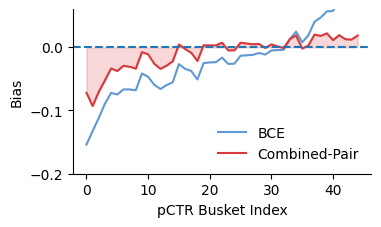

In [20]:
twitter_color = '#D9383A'
base_color = '#5F98D2'
jrc_color='#96C37D'

fig,ax=plt.subplots(figsize=(4,2.6))
plot_baskets_paper(
    [range(len(np.array(intvs)))]*2,
    results,
    ['BCE','Combined-Pair'],
    xlabel='pCTR Busket Index',
    ylabel='Bias',
    title='Bias',
    ann=False,
    color=[base_color,twitter_color],
    ls=['-','-']
)
plt.ylim(-0.2,0.06)
plt.fill_between(range(len(np.array(intvs))), 0,results[1], color=twitter_color, alpha=0.2)
plt.title('')
plt.legend(loc='lower right',frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('../../../../figure/bias.pdf',dpi=400,bbox_inches='tight')

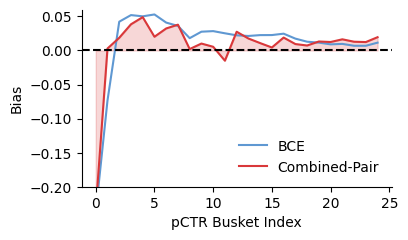

In [19]:
import matplotlib.pyplot as plt
import numpy as np
twitter_color = '#D9383A'
base_color = '#5F98D2'
jrc_color='#96C37D'

online_bias = pd.read_csv('../tmp_res/online_bias.csv')
x = online_bias['pCTR Group']
A = online_bias['Control Group']
B = online_bias['Experimental Group']

# 计算两条曲线的差距
diff = B - 0
fig,ax=plt.subplots(figsize=(4,2.3))
# 绘制曲线和阴影
plt.plot(x, A, label='BCE',color=base_color)
plt.plot(x, B, label='Combined-Pair',color=twitter_color)
plt.fill_between(x, 0,B, color=twitter_color, alpha=0.2)

plt.axhline(0,ls='--',color='k')
plt.legend(frameon=False)
# plt.xticks(range(len(A)-5))
# plt.title('Difference between A and B')
xlabel='pCTR Busket Index'
ylabel='Bias'
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.ylim(-0.2,0.06)
plt.savefig('../../../../figure/online_bias.pdf',dpi=400,bbox_inches='tight')
plt.show()